In [1]:
import scanpy as sc
import mudata as md
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from latentcor import gen_data, get_tps, latentcor

import scrublet as scr
import scipy.io
import time
import pickle

np.random.seed(42)

In [2]:
path_nSBM = '../data/mudata_nSBM_hierarchy_2.h5mu'
path_KEGG = '../data/mudata_KEGG_hierarchy_2.h5mu'
path_phrog = '../data/mudata_phrog_hierarchy_2.h5mu'

In [3]:
data_nSBM = md.read_h5mu(path_nSBM)

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\anndata\_core\anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\anndata\_core\anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\anndata\_core\anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [4]:
data_gex = data_nSBM['SC_genes'].copy()
data_gex = data_gex[data_gex.obs['strains'] == 'GSM5456503_Ec_CDS']

In [5]:
sc.pp.calculate_qc_metrics(data_gex, var_type="genes", percent_top=None, log1p=False, inplace=True)

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


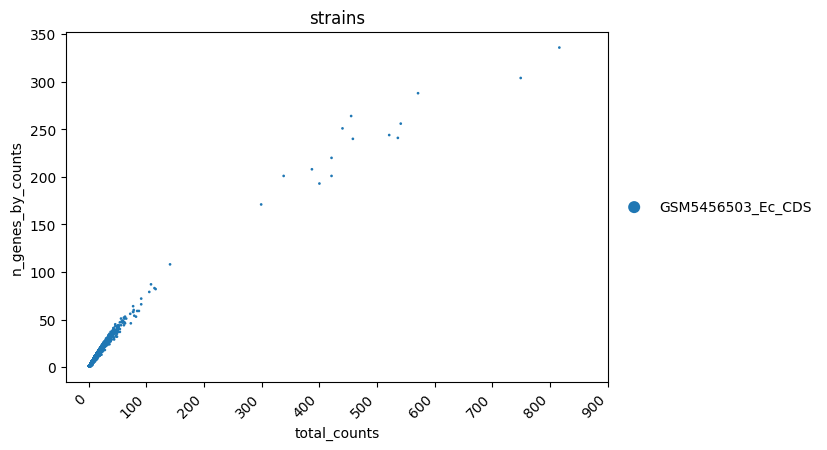

In [6]:
g = sc.pl.scatter(data_gex, x='total_counts', y='n_genes_by_counts', color="strains", show=False, size=15)
g.set_xticks(ticks=range(0, 1000, 100))
g.set_xticklabels(labels=range(0, 1000, 100), rotation=45, ha="right")
plt.show()

In [7]:
print('original data shape:\t\t\t\t', data_gex.shape)
sc.pp.filter_cells(data_gex, min_genes=5)
print('remove cells that have less than 5 genes:\t', data_gex.shape)
sc.pp.filter_cells(data_gex, max_counts=250)
print('remove cells that have more than 250 genes:\t', data_gex.shape)
sc.pp.filter_genes(data_gex, min_cells=1)
print('remove genes that dont appear:\t\t\t', data_gex.shape)

original data shape:				 (9654, 13536)
remove cells that have less than 5 genes:	 (5979, 13536)
remove cells that have more than 250 genes:	 (5964, 13536)
remove genes that dont appear:			 (5964, 3379)


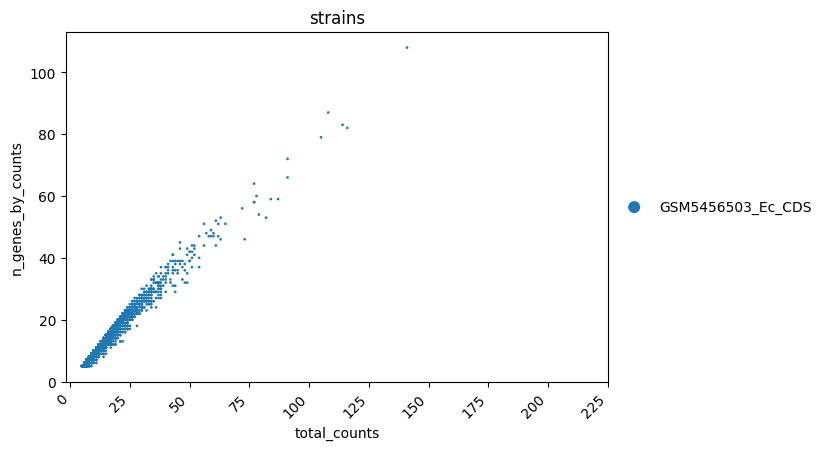

In [34]:
g = sc.pl.scatter(data_gex, x='total_counts', y='n_genes_by_counts', color="strains", show=False, size=15)
g.set_xticks(ticks=range(0, 250, 25))
g.set_xticklabels(labels=range(0, 250, 25), rotation=45, ha="right")
plt.show()

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(


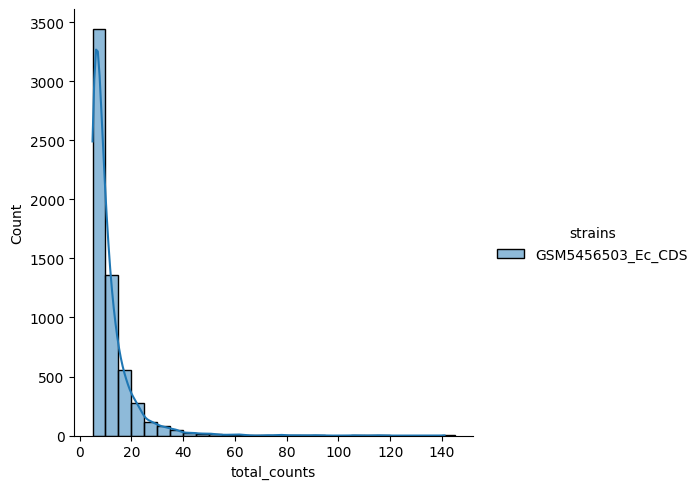

In [35]:
sns.displot(data_gex.obs, x="total_counts", binwidth=5, kde=True, hue="strains")
plt.show()

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(


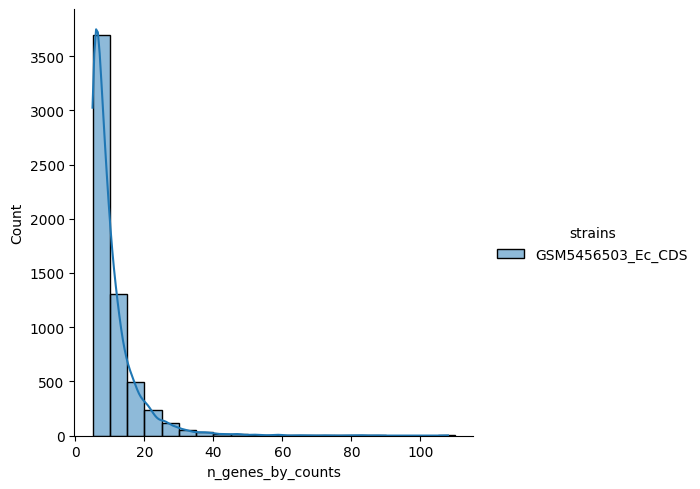

In [36]:
sns.displot(data_gex.obs, x="n_genes_by_counts", binwidth=5, kde=True, hue="strains")
plt.show()

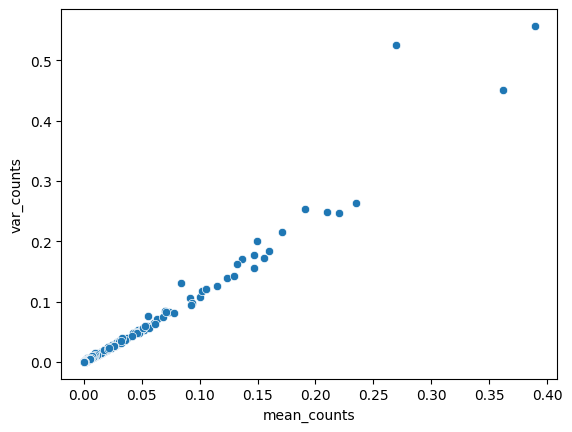

In [37]:
data_gex.var["var_counts"] = np.asarray(np.var(data_gex.X.todense(), axis=0)).squeeze()
data_gex.var["mean_counts"] = np.asarray(np.mean(data_gex.X.todense(), axis=0)).squeeze()
sns.scatterplot(data=data_gex.var, x="mean_counts", y="var_counts")
plt.show()

In [38]:
data_gex.layers["counts"] = data_gex.X
data_gex.layers["counts_scaled"] = sc.pp.scale(data_gex.X, max_value=10)
data_gex.layers["sqrt_counts"] = np.sqrt(data_gex.X)
data_gex.layers["sqrt_counts_scaled"] = sc.pp.scale(np.sqrt(data_gex.X), max_value=10)

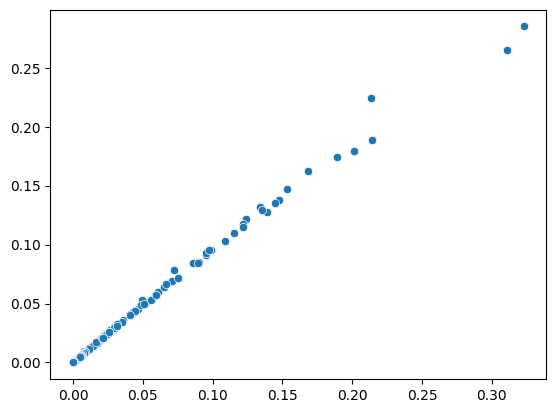

In [39]:
x = np.asarray(np.mean(data_gex.layers["sqrt_counts"].A, axis=0)).squeeze()
y = np.asarray(np.var(data_gex.layers["sqrt_counts"].A, axis=0)).squeeze()
sns.scatterplot(x=x,y=y)
plt.show()

In [40]:
data_gex

AnnData object with n_obs × n_vars = 5964 × 3642
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'n_genes', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'var_counts'
    uns: 'genes_match', 'protein_match', 'unmatch_genes', 'strains_colors'
    layers: 'counts', 'counts_scaled', 'sqrt_counts', 'sqrt_counts_scaled'

In [42]:
sc.write(filename='../data/ec_prepro.h5ad', adata=data_gex)

### Select 50 HVG

In [14]:
sc.pp.highly_variable_genes(data_gex, n_top_genes=50)
data_gex = data_gex[:, data_gex.var['highly_variable']]

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


In [17]:
get_tps(data_gex.layers['counts'].A)

ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by eith

array(['tru', 'tru', 'ter', 'ter', 'ter', 'bin', 'ter', 'tru', 'tru',
       'ter', 'ter', 'ter', 'bin', 'ter', 'bin', 'ter', 'ter', 'tru',
       'ter', 'tru', 'ter', 'ter', 'ter', 'ter', 'ter', 'ter', 'tru',
       'ter', 'ter', 'ter', 'ter', 'ter', 'bin', 'tru', 'ter', 'tru',
       'tru', 'ter', 'tru', 'ter', 'ter', 'tru', 'ter', 'ter', 'ter',
       'tru', 'tru', 'ter', 'ter', 'bin'], dtype='<U3')

In [19]:
tps = ['tru' for i in range(data_gex.shape[1])]

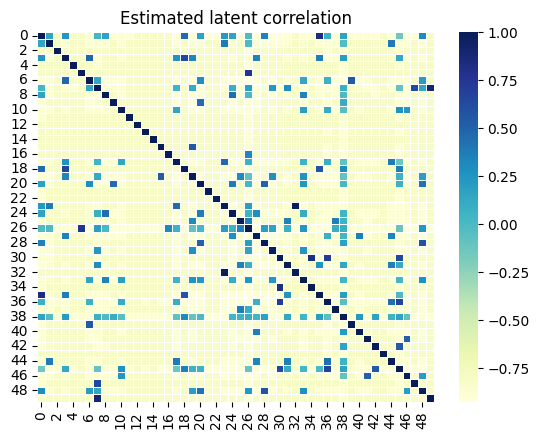

In [21]:
estimate = latentcor(data_gex.layers['counts'].A, tps=tps, showplot=True, use_nearPD=False, method='original')

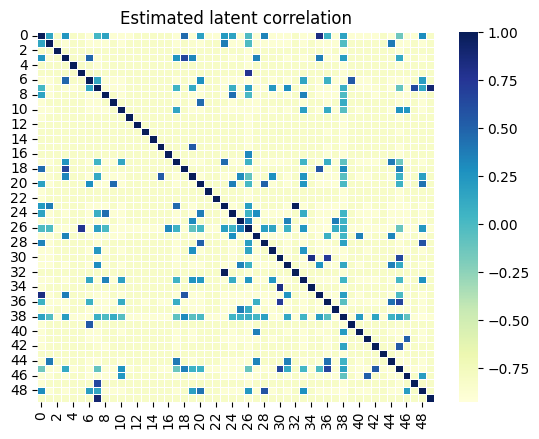

In [28]:
sqrt_estimate = latentcor(data_gex.layers['sqrt_counts'].A, tps=tps, showplot=True, use_nearPD=False, method='original')

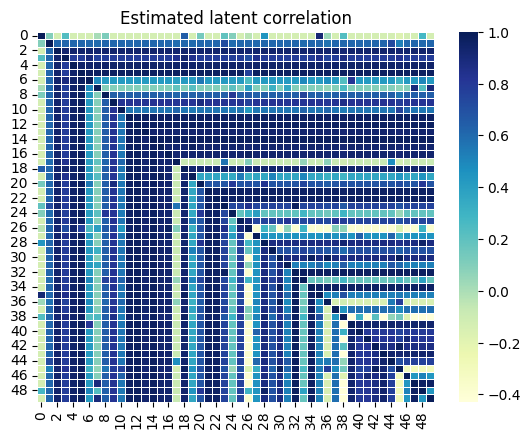

In [27]:
estimate_approx = latentcor(data_gex.layers['counts'].A, tps=tps, showplot=True, use_nearPD=False, method='approx')

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\statsmodels\stats\correlation_tools.py:90: IterationLimitWarning: 
Maximum iteration reached.

  warnings.warn(iteration_limit_doc, IterationLimitWarning)


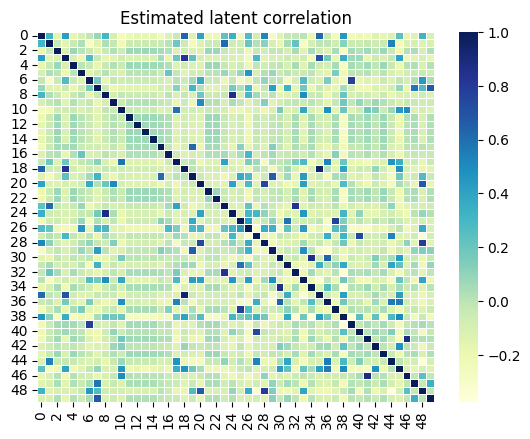

In [29]:
estimate_pd = latentcor(data_gex.layers['counts'].A, tps=tps, showplot=True, use_nearPD=True, method='original')

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\statsmodels\stats\correlation_tools.py:90: IterationLimitWarning: 
Maximum iteration reached.

  warnings.warn(iteration_limit_doc, IterationLimitWarning)


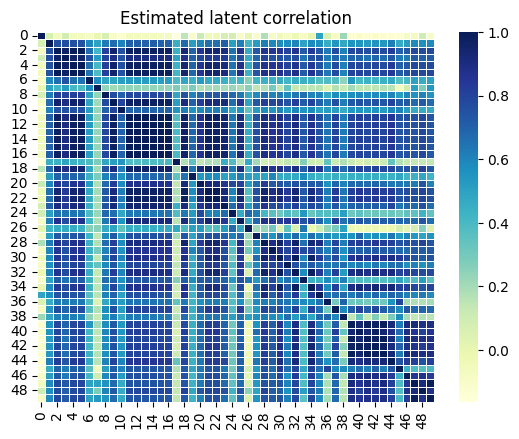

In [30]:
estimate_pd_approx = latentcor(data_gex.layers['counts'].A, tps=tps, showplot=True, use_nearPD=True, method='approx')

In [31]:
with open('../data/est_original_50.pkl', 'wb') as f:
    pickle.dump(estimate, f)

with open('../data/estimate_pd_original_50.pkl', 'wb') as f:
    pickle.dump(estimate_pd, f)

### Random select 50 genes

In [14]:
# Number of True entries
num_true_entries = 50  # You can adjust this to your desired number

# Create a boolean array with True entries at random positions
random_bool_array = np.full(data_gex.shape[1], False)
random_indices = np.random.choice(data_gex.shape[1], num_true_entries, replace=False)
random_bool_array[random_indices] = True

In [15]:
random_indices

array([ 415, 3252, 3193,  298, 1874, 2691,   32, 2862, 2629, 3038,  657,
       2972, 2538, 2335, 1831, 1044, 2043, 1074,  897, 3230, 1206, 2709,
        315,  461, 2536,   17, 1452,  149,  807, 1927,   93, 1747,  291,
       3079,  964, 1902, 2345, 3636, 3634, 1052,  932,  940, 2348, 3544,
       2807, 3599,  700,  120, 2653, 2422])

In [16]:
data_gex = data_gex[:, random_indices]

In [19]:
tps = ['tru' for i in range(data_gex.shape[1])]

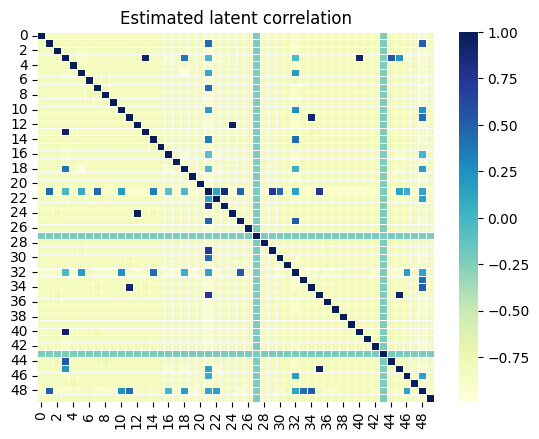

In [20]:
estimate = latentcor(data_gex.layers['counts'].A, tps=tps, showplot=True, use_nearPD=False, method='original')

In [22]:
estimate_approx = latentcor(data_gex.layers['counts'].A, tps=tps, showplot=True, use_nearPD=False, method='approx')

ValueError: One of the requested xi is out of bounds in dimension 0

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\statsmodels\stats\correlation_tools.py:90: IterationLimitWarning: 
Maximum iteration reached.

  warnings.warn(iteration_limit_doc, IterationLimitWarning)


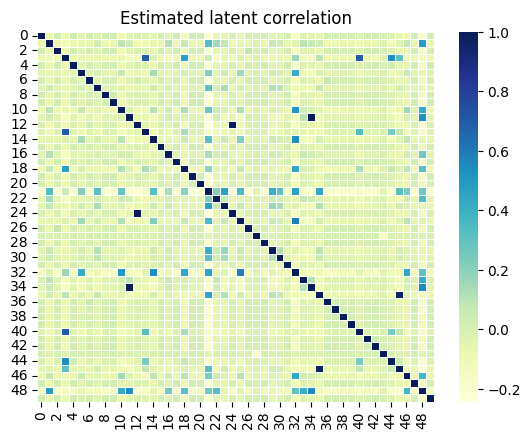

In [24]:
estimate_pd = latentcor(data_gex.layers['counts'].A, tps=tps, showplot=True, use_nearPD=True, method='original')

In [27]:
estimate_pd_approx = latentcor(data_gex.layers['counts'].A, tps=tps, showplot=True, use_nearPD=True, method='approx')

ValueError: One of the requested xi is out of bounds in dimension 0

In [26]:
with open('../data/est_original_50_rnd.pkl', 'wb') as f:
    pickle.dump(estimate, f)

with open('../data/est_pd_original_50_rnd.pkl', 'wb') as f:
    pickle.dump(estimate_pd, f)

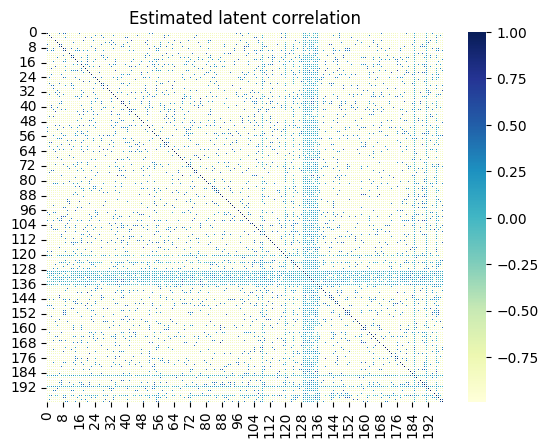

In [128]:
estimate = latentcor(data_gex.layers['sqrt_counts'].A, tps=tps, showplot=True, use_nearPD=False, method='original')

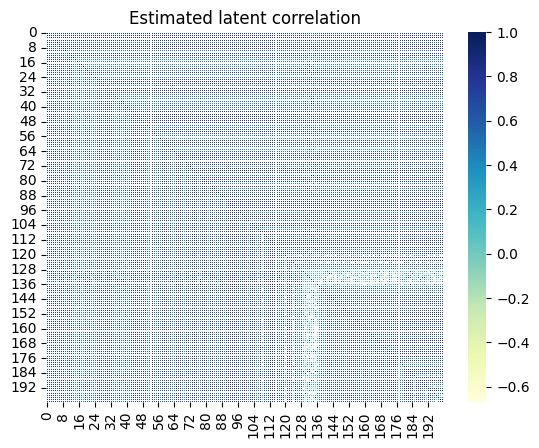

In [129]:
estimate_approx = latentcor(data_gex.layers['sqrt_counts'].A, tps=tps, showplot=True, use_nearPD=False, method='approx')

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\statsmodels\stats\correlation_tools.py:90: IterationLimitWarning: 
Maximum iteration reached.

  warnings.warn(iteration_limit_doc, IterationLimitWarning)


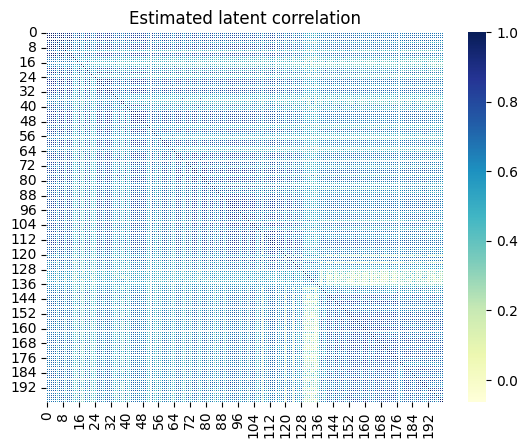

In [130]:
estimate_pd_approx = latentcor(data_gex.layers['sqrt_counts'].A, tps=tps, showplot=True, use_nearPD=True, method='approx')

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\statsmodels\stats\correlation_tools.py:90: IterationLimitWarning: 
Maximum iteration reached.

  warnings.warn(iteration_limit_doc, IterationLimitWarning)


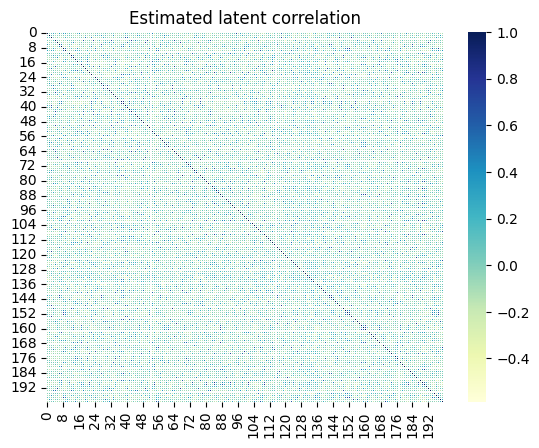

In [131]:
estimate_pd_original = latentcor(data_gex.layers['sqrt_counts'].A, tps=tps, showplot=True, use_nearPD=True, method='original')

In [134]:
#2 min, 2 sec, 15min, 17 min

with open('../data/est_original.pkl', 'wb') as f:
    pickle.dump(estimate, f)

with open('../data/est_approx.pkl', 'wb') as f:
    pickle.dump(estimate_approx, f)

with open('../data/est_pd_original.pkl', 'wb') as f:
    pickle.dump(estimate_pd_original, f)

with open('../data/est_pd_approx.pkl', 'wb') as f:
    pickle.dump(estimate_pd_approx, f)

In [5]:
with open('../data/est_original.pkl', 'rb') as f:
    est = pickle.load(f)

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


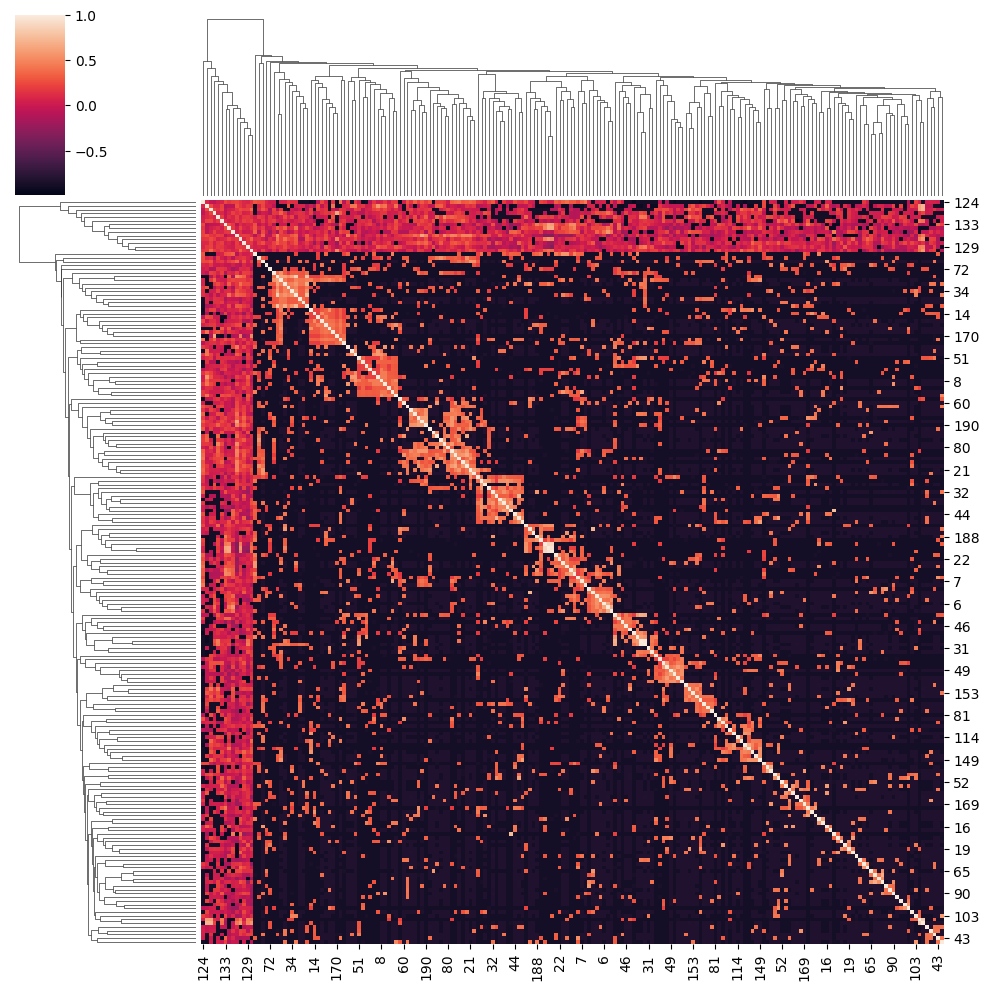

In [9]:
sns.clustermap(est['R'])

In [10]:
with open('../data/est_pd_original.pkl', 'rb') as f:
    est_pd = pickle.load(f)

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


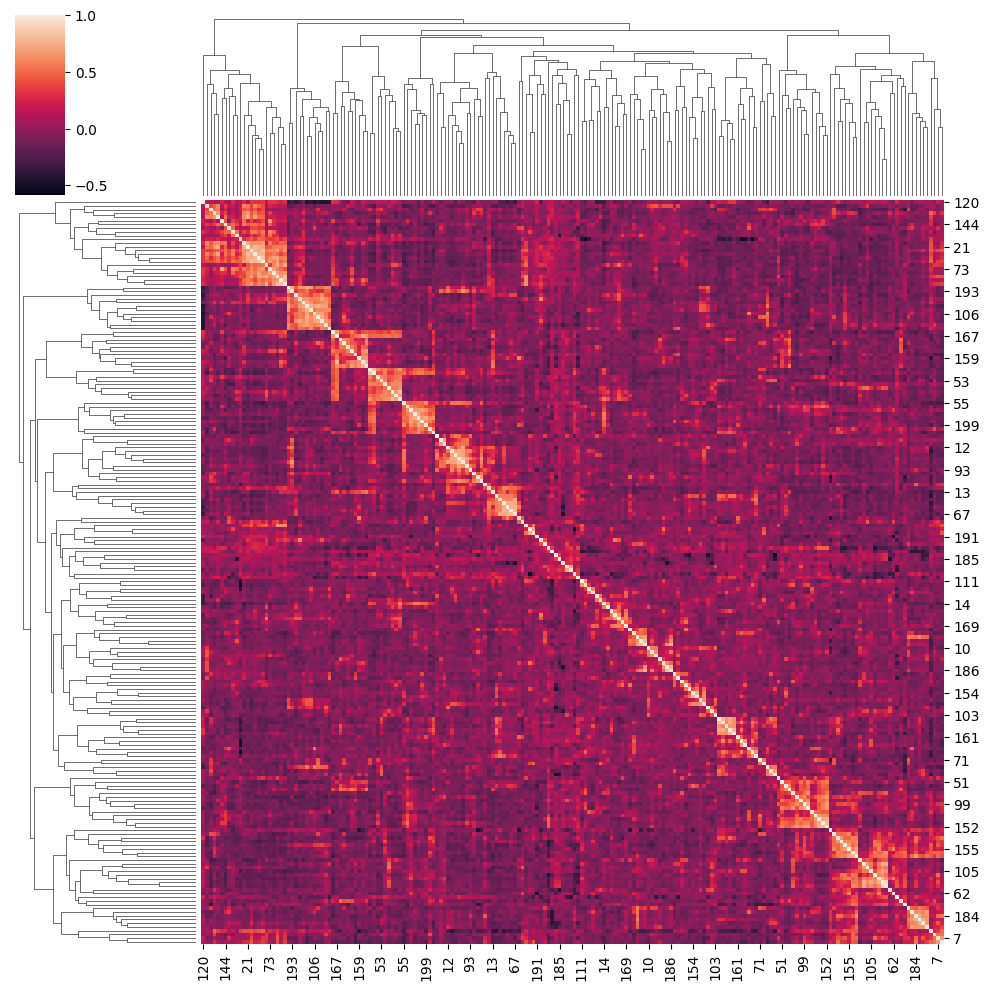

In [11]:
sns.clustermap(est_pd['R'])

In [ ]:
#2 min, 2 sec, 15min, 17 min

In [ ]:
adata_tmp.obs['doublet_score'] = np.zeros(adata_tmp.shape[0])
adata_tmp.obs['doublet'] = np.zeros(adata_tmp.shape[0])

# filtering / preprocessing parameters:
min_counts = 2
min_cells = 3
vscore_percentile = 85
n_pc = 50

# doublet detector parameters
expected_doublet_rate = 0.02
sim_doublet_ratio = 3
n_neighbors = 15

for batch in enumerate(adata_tmp.obs['donor'].cat.categories):
    print(batch)
    t0 = time.time()
    idx = np.flatnonzero(adata_tmp.obs['donor']==batch[1])
    scrub = scr.Scrublet(counts_matrix = adata_tmp[idx, :].X,
                        n_neighbors = n_neighbors,
                        sim_doublet_ratio = sim_doublet_ratio,
                        expected_doublet_rate = expected_doublet_rate)
    doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts = min_counts,
                                                              min_cells = min_cells,
                                                              n_prin_comps = n_pc,
                                                              use_approx_neighbors = True,
                                                              get_doublet_neighbor_parents = False)
    adata_tmp.obs['doublet_score'].iloc[idx] = doublet_scores
    adata_tmp.obs['doublet'].iloc[idx] = predicted_doublets
    t1 = time.time()
    print('Elapsed time: {:.1f} seconds'.format(t1-t0))

rcParams['figure.figsize'] = (6, 6)
sb.distplot(adata_tmp.obs['doublet_score'], bins=100, kde=False)

thr = 0.05
idx_filter = adata_tmp.obs['doublet_score'] <= thr

adata_tmp = adata_tmp[idx_filter].copy()
print(f'Number of cells after double filter: {adata_tmp.n_obs}')